In [3]:
import scanpy as sc
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [4]:
with open("data_augmentation_GSE174188.csv", 'r') as file:
    df = pd.read_csv(file, index_col = 0)

age = df["age"].astype(int)
#df = df.drop(columns = ["mean_DC","std_NK", "std_CD4T", "std_CD8T", "std_B", "std_Monocyte", "std_DC"], axis = 1 )
df = df.drop(columns = "age", axis = 1)

In [5]:
df

,mean_NK,mean_CD4T,mean_CD8T,mean_B,mean_Monocyte,mean_DC,std_NK,std_CD4T,std_CD8T,std_B,std_Monocyte,std_DC
HC-519_1,4.250463,2.101322,2.585653,2.275958,4.256917,0.995282,0.219740,0.153563,0.140392,0.173827,0.270898,0.039002
HC-519_2,4.233671,2.125010,2.608677,2.249835,4.300351,0.978386,0.199198,0.149960,0.197166,0.096902,0.258499,0.085476
HC-519_3,4.266166,2.135315,2.601588,2.236187,4.253217,0.953375,0.223695,0.177710,0.155687,0.186116,0.216263,0.043319
HC-519_4,4.273546,2.080197,2.601157,2.238966,4.264690,0.994676,0.217150,0.174626,0.163971,0.186315,0.261485,0.086960
HC-519_5,4.324083,2.141739,2.615713,2.262450,4.253062,0.957692,0.228844,0.132216,0.144391,0.153588,0.193030,0.050106
...,...,...,...,...,...,...,...,...,...,...,...,...
IGTB1731_IGTB1731_6,6.563656,3.568826,4.199865,3.961308,5.613795,1.637987,0.244200,0.189973,0.159651,0.136891,0.203070,0.122695
IGTB1731_IGTB1731_7,6.596188,3.580332,4.289095,3.913684,5.553950,1.640019,0.258587,0.130674,0.185953,0.124926,0.246717,0.078834
IGTB1731_IGTB1731_8,6.592616,3.584274,4.251048,3.960035,5.568194,1.599903,0.241156,0.173601,0.174416,0.155811,0.245737,0.078717
IGTB1731_IGTB1731_9,6.570584,3.537206,4.293931,3.941113,5.570133,1.641331,0.227840,0.175775,0.160713,0.160330,0.211768,0.060764


In [6]:
def XGBR(df, age, test_size=0.3, n_estimators=65, max_depth=4, colsample_bytree = 1, gamma = 0.1, min_child_weight = 1, subsample = 0.8):
    X_train, X_test, y_train, y_test = train_test_split(df, age, test_size=test_size, random_state=42)
    # n_jobs=-1處理器全開
    xgbrModel = xgb.XGBRegressor(n_estimators = n_estimators, n_jobs=-1, max_depth = max_depth,
                                 colsample_bytree = colsample_bytree, gamma = gamma, min_child_weight = min_child_weight,
                                subsample = subsample, eval_metric="rmse")  
    # 創建k折交叉驗證對象
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # 進行 k-fold cross-validation，例如 k=10
    scores = cross_val_score(xgbrModel, df, age, cv=kf)
    print('Cross-validation scores: ', scores)

    # train model with early stopping
    eval_set = [(X_test, y_test)]
    xgbrModel.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    y_pred = xgbrModel.predict(X_test)

    # 計算均方誤差（Mean Squared Error, MSE）
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error (MSE): {mse}')

    # 計算平均絕對誤差（Mean Absolute Error, MAE）
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error (MAE): {mae}')

    # 預測成功的比例
    print('Train Set score: ',xgbrModel.score(X_train,y_train))
    print('Test Set score: ',xgbrModel.score(X_test,y_test))
    # 計算皮爾森相關係數
    corr, _ = pearsonr(y_test, y_pred)
    print(f'Pearson correlation: {corr}')
    plt.scatter(y_test, y_pred, s=10, label='True')
    plt.xlabel('Actual Ages')
    plt.ylabel('Predicted Ages')
    plt.title('Actual vs Predicted Ages')
    plt.show()


    print('特徵重要程度: ',xgbrModel.feature_importances_)

Cross-validation scores:  [0.78940672 0.86434103 0.83617538 0.76729006 0.81356289 0.78763416
 0.87175947 0.8210697  0.79493122 0.79850159]
Mean Squared Error (MSE): 38.90042275546086
Mean Absolute Error (MAE): 4.634787442027658
Train Set score:  0.8960513369685078
Test Set score:  0.7907099193803967
Pearson correlation: 0.8931235368505348


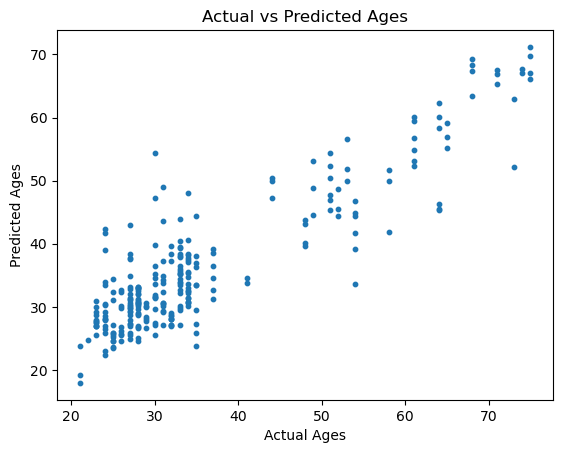

特徵重要程度:  [0.06911699 0.12526718 0.17216967 0.23003656 0.11286313 0.12280353
 0.02145823 0.02659206 0.03242474 0.01486913 0.05419618 0.01820261]


In [8]:
XGBR(df, age, test_size=0.3, n_estimators=65, max_depth=2, colsample_bytree = 1, gamma = 0.1, min_child_weight = 1, subsample = 0.8)

Cross-validation scores:  [0.78940672 0.86434103 0.83617538 0.76729006 0.81356289 0.78763416
 0.87175947 0.8210697  0.79493122 0.79850159]
Mean Squared Error (MSE): 31.653958036867074
Mean Absolute Error (MAE): 4.2930609454279365
Train Set score:  0.9040322390345569
Test Set score:  0.8231271058197247
Pearson correlation: 0.9138451760382815


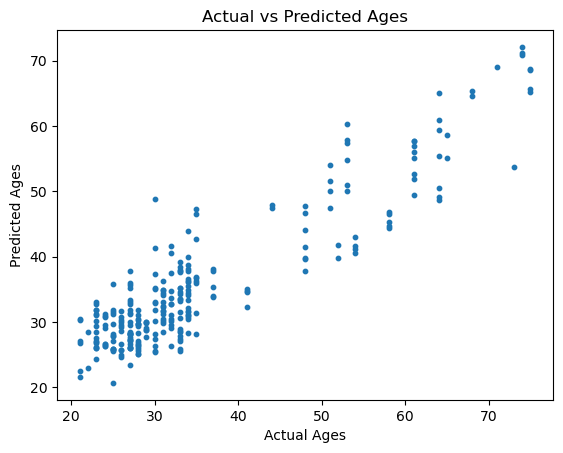

特徵重要程度:  [0.07617872 0.09328384 0.17836668 0.19356646 0.09898719 0.1447762
 0.0480167  0.02879195 0.02025982 0.03282084 0.03788171 0.04706994]


In [20]:
X_train, X_test, y_train, y_test = train_test_split(df, age, test_size=0.3)
# n_jobs=-1處理器全開
xgbrModel = xgb.XGBRegressor(n_estimators = 65, n_jobs=-1, max_depth = 2,
                            colsample_bytree = 1, gamma = 0.1, min_child_weight = 1,
                            subsample = 0.8, eval_metric="rmse")  
# 創建k折交叉驗證對象
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 進行 k-fold cross-validation，例如 k=10
scores = cross_val_score(xgbrModel, df, age, cv=kf)
print('Cross-validation scores: ', scores)

# train model with early stopping
eval_set = [(X_test, y_test)]
xgbrModel.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

y_pred = xgbrModel.predict(X_test)

# 計算均方誤差（Mean Squared Error, MSE）
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# 計算平均絕對誤差（Mean Absolute Error, MAE）
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# 預測成功的比例
print('Train Set score: ',xgbrModel.score(X_train,y_train))
print('Test Set score: ',xgbrModel.score(X_test,y_test))
# 計算皮爾森相關係數
corr, _ = pearsonr(y_test, y_pred)
print(f'Pearson correlation: {corr}')
plt.scatter(y_test, y_pred, s=10, label='True')
plt.xlabel('Actual Ages')
plt.ylabel('Predicted Ages')
plt.title('Actual vs Predicted Ages')
plt.show()


print('特徵重要程度: ',xgbrModel.feature_importances_)